# Reconstructed quantities

This notebook looks at how accurately we can reconstruct various quantities. To avoid having to run `CAMB` each time we perform a likelihood evaluation, we generate a fiducial cosmology and use this in the reconstruction. Previously we have kept fixed the growth rate and $h$ in our simulations, and in these cases the reconstruction of $H(z)$ and the comoving linear power spectrum is extremely accurate. However now we are considering varying $h$ and the growth, and we need to examine how well this reconstruction works in these cases.

In this notebook we look at how accurately $H(z)$ is reconstructed. For the comoving linear power spectrum, we focus on $\Delta^2_p$, $n_p$ and $\alpha_p$ rather than looking at the full power spectrum, as the full power spectrum is never actually used in the code.

We start off by looking at reconstructions of $H(z)$.

In [1]:
import camb_cosmo
import camb
import recons_cosmo
import fit_linP
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cosmo_fid = camb_cosmo.get_cosmology() ## Fiducial cosmology
cosmo_as=camb_cosmo.get_cosmology(As=2.05e-09) ## Cosmology where we change A_s
cosmo_ns=camb_cosmo.get_cosmology(ns=0.92) ## Cosmology where we change n_s
cosmo_h=camb_cosmo.get_cosmology(H0=74.) ## Cosmology where we change H0

## Fit a LinearPowerModel to each cosmology
linP_fid=fit_linP.LinearPowerModel(cosmo=cosmo_fid,k_units="kms")
linP_h=fit_linP.LinearPowerModel(cosmo=cosmo_h,k_units="kms")
linP_as=fit_linP.LinearPowerModel(cosmo=cosmo_as,k_units="kms")
linP_ns=fit_linP.LinearPowerModel(cosmo=cosmo_ns,k_units="kms")

zs=[2.0,3.0,5.0] ## zs we're going to test for the power spectrum reconstructions

In [3]:
## Create a recons_cosmo object
recons=recons_cosmo.ReconstructedCosmology(cosmo_fid=cosmo_fid,zs=zs)

Note: redshifts have been re-sorted (earliest first)


### Reconstructing $H(z)$
Here we test how accurate $H(z)$ reconstructions are. All I'm doing here is comparing the true $H(z)$ as output by `CAMB` with the reconstructed one, although I'm not sure if degeneracies will play a role here.


In [4]:
print("Fiducial parameters:", linP_fid.get_params())
print("Test cosmology parameters:", linP_h.get_params())

Fiducial parameters: {'Delta2_star': 0.36017590528642224, 'n_star': -2.299335667257498, 'alpha_star': -0.2165270371207302, 'f_star': 0.9813695578403183, 'g_star': 0.9677508579459803}
Test cosmology parameters: {'Delta2_star': 0.36010576390340093, 'n_star': -2.3004640097099234, 'alpha_star': -0.21599697156495193, 'f_star': 0.9757862929001873, 'g_star': 0.9577005905767146}


In [5]:
## Test how well H(z) is reconstructed
zs_h=np.linspace(2,5,100).tolist()
results_h = camb.get_results(cosmo_h.set_matter_power(redshifts=zs_h, kmax=2.0)) ## Run CAMB on cosmology with h=0.74

true_h=np.empty(len(zs_h))
recons_h=np.empty(len(zs_h))
for aa in range(len(zs_h)):
    true_h[aa]=results_h.hubble_parameter(zs_h[aa])
    recons_h[aa]=recons.reconstruct_Hubble(zs_h[aa],linP_h) ## Different h to fiducial cosmology

Note: redshifts have been re-sorted (earliest first)


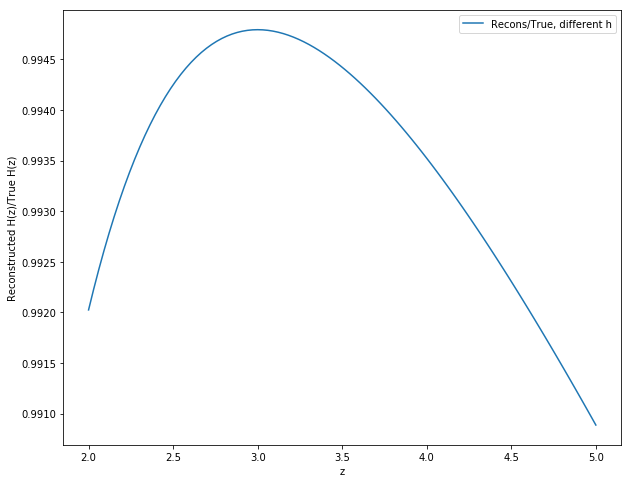

In [6]:
plt.figure(figsize=(10,8))
plt.plot(zs_h,recons_h/true_h,label="Recons/True, different h")
plt.xlabel("z")
plt.ylabel("Reconstructed H(z)/True H(z)")
plt.legend()

Honestly not sure how much we can read into this plot, I don't think I'm thinking about this in the correct way still. For one thing, there are degeneracies in the way the $\Lambda$CDM parameters map into our likelihood parameters so I don't know to what extent this is actually a measure of the accuracy of the reconstruction. Secondly, the two places that $H(z)$ is used is in the converstion of the linear power from velocity units to comoving, and the conversion of the $P_{1D}$ from comoving to velocity units, and its hard to say what the required accuracy there is.

## Comoving linear power

The way the code is set up right now, we would not expect it to work in reconstructing the comoving linear power when varying $h$. We label fiducial quantities with the subscript $0$, and the conversion factor from velocity to comoving units is $a_\nu=(1+z)/H(z)$. The power spectrum in velocity units is $P^\prime$. The comoving power spectrum is reconstructed using:

$$ P(q/a_{\nu 0})=\frac{P^\prime(q)}{P^\prime_0(q)}P_0(q/a_{\nu 0}) $$

which assumes the same $h$ in each cosmology. This needs to be extended to:

$$ P(q/a_{\nu})=\bigg(\frac{H_0(z)}{H(z)}\bigg)^3\frac{P^\prime(q,z)}{P^\prime_0(q,z)}{P_0(q/a_{\nu 0})} $$


In the plots below I compare these two approaches, labelled 'old' and 'new'.

In [7]:
def print_params(k,pk):
    """ Perform fit on the comoving linear power and print
    the emulator parameters """
    
    linP_fit=fit_linP.fit_polynomial(xmin,xmax,k/kp_Mpc,pk)
    
    # compute parameters used in emulator
    lnA_p=linP_fit[0]
    Delta2_p=np.exp(lnA_p)*kp_Mpc**3/(2*np.pi**2)
    n_p=linP_fit[1]
    
    # note that the curvature is alpha/2
    alpha_p=2.0*linP_fit[2]
    params={'Delta2_p':Delta2_p,'n_p':n_p,'alpha_p':alpha_p}
    print(params)

In [8]:
## Set up limits for fit (same as used in the likelihood evaluations)
kp_Mpc=recons.kp_Mpc
kmin_Mpc=0.5*kp_Mpc
kmax_Mpc=2.0*kp_Mpc
xmin=kmin_Mpc/kp_Mpc
xmax=kmax_Mpc/kp_Mpc

#### Simple test case, only $\Delta^2_\star$ changed

Just to demonstrate that things are working ok, we compare the reconstructed $\Delta^2_p$, $n_p$ and $\alpha_p$ when we have changed only $A_s$ in the test cosmology, and show that the comoving values are accurate.

In [9]:
## Compare fit with truth for old and new approaches when changing $Delta2_star$
k_true,z_true,pk_true=camb_cosmo.get_linP_Mpc(cosmo_as,zs)
for aa in range(len(zs)):
    print("\n z=",zs[aa])
    k_old,pk_old=recons.reconstruct_linP_Mpc_old(zs[aa],linP_as,recons.linP_Mpc_fid[aa])
    k_new,pk_new=recons.reconstruct_linP_Mpc_new(zs[aa],linP_as,recons.linP_Mpc_fid[aa])
    print("Old:")
    print_params(k_old,pk_old)
    print("New:")
    print_params(k_new,pk_new)
    print("True:")
    print_params(k_true,pk_true[aa])

Note: redshifts have been re-sorted (earliest first)

 z= 2.0
Old:
{'alpha_p': -0.2163759500235648, 'Delta2_p': 0.6150710858466475, 'n_p': -2.299479324210559}
New:
{'alpha_p': -0.2163759500235648, 'Delta2_p': 0.6150710858466475, 'n_p': -2.299479324210559}
True:
{'alpha_p': -0.21637595002363266, 'Delta2_p': 0.6150710858466479, 'n_p': -2.2994793242105533}

 z= 3.0
Old:
{'alpha_p': -0.21637600594733514, 'Delta2_p': 0.35173753705831096, 'n_p': -2.2994794594828276}
New:
{'alpha_p': -0.21637600594733514, 'Delta2_p': 0.35173753705831096, 'n_p': -2.2994794594828276}
True:
{'alpha_p': -0.21637600594740586, 'Delta2_p': 0.35173753705831107, 'n_p': -2.2994794594828223}

 z= 5.0
Old:
{'alpha_p': -0.21637705456781514, 'Delta2_p': 0.1577871037339744, 'n_p': -2.2994799859998474}
New:
{'alpha_p': -0.21637705456781514, 'Delta2_p': 0.1577871037339744, 'n_p': -2.2994799859998474}
True:
{'alpha_p': -0.2163770545678929, 'Delta2_p': 0.15778710373397448, 'n_p': -2.299479985999843}


#### Changing $h$

Here we do the same with a test cosmology with $h=0.74$. This results in all likelihood parameters changing:

In [10]:
print("Fiducial parameters:", linP_fid.get_params())
print("Test cosmology parameters:", linP_h.get_params())

Fiducial parameters: {'Delta2_star': 0.36017590528642224, 'n_star': -2.299335667257498, 'alpha_star': -0.2165270371207302, 'f_star': 0.9813695578403183, 'g_star': 0.9677508579459803}
Test cosmology parameters: {'Delta2_star': 0.36010576390340093, 'n_star': -2.3004640097099234, 'alpha_star': -0.21599697156495193, 'f_star': 0.9757862929001873, 'g_star': 0.9577005905767146}


In [11]:
## Now compare with the different h cosmology
results_h = camb.get_results(cosmo_h.set_matter_power(redshifts=zs_h, kmax=2.0))
k_true,z_true,pk_true=camb_cosmo.get_linP_Mpc(cosmo_h,zs)
for aa in range(len(zs)):
    print("\n z=",zs[aa])
    k_old,pk_old=recons.reconstruct_linP_Mpc_old(zs[aa],linP_h,recons.linP_Mpc_fid[aa])
    k_new,pk_new=recons.reconstruct_linP_Mpc_new(zs[aa],linP_h,recons.linP_Mpc_fid[aa])
    print("Old:")
    print_params(k_old,pk_old)
    print("New:")
    print_params(k_new,pk_new)
    print("True:")
    print_params(k_true,pk_true[aa])

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)

 z= 2.0
Old:
{'alpha_p': -0.2158458844678567, 'Delta2_p': 0.6281927561244831, 'n_p': -2.300607666662979}
New:
{'alpha_p': -0.21627387240236728, 'Delta2_p': 0.6265540706126858, 'n_p': -2.299768845922468}
True:
{'alpha_p': -0.21638209028857808, 'Delta2_p': 0.6245944619576621, 'n_p': -2.2994697819424297}

 z= 3.0
Old:
{'alpha_p': -0.21584594039162708, 'Delta2_p': 0.36024633261381817, 'n_p': -2.300607801935248}
New:
{'alpha_p': -0.21584594039162708, 'Delta2_p': 0.36024633261381817, 'n_p': -2.300607801935248}
True:
{'alpha_p': -0.21638335636132996, 'Delta2_p': 0.35894011612837046, 'n_p': -2.2994701503556723}

 z= 5.0
Old:
{'alpha_p': -0.215846989012124, 'Delta2_p': 0.16250763031994847, 'n_p': -2.3006083284522663}
New:
{'alpha_p': -0.21506168722985836, 'Delta2_p': 0.1633626974178941, 'n_p': -2.3022476943336323}
True:
{'alpha_p': -0.21638434948164045, 'Delta2_p': 0.16144853102983253, 'n_

We know that there is some inaccuracy in the $H(z)$ reconstruction that is used in `recons.reconstruct_linP_Mpc_new`, so to temporarily eliminiate this, you can pass `true_H` as an argument to use the $H(z)$ from `CAMB` instead of the reconstructed value.

In [12]:
results_h = camb.get_results(cosmo_h.set_matter_power(redshifts=zs_h, kmax=2.0))
k_true,z_true,pk_true=camb_cosmo.get_linP_Mpc(cosmo_h,zs)
for aa in range(len(zs)):
    print("\n z=",zs[aa])
    k_old,pk_old=recons.reconstruct_linP_Mpc_old(zs[aa],linP_h,recons.linP_Mpc_fid[aa])
    k_new,pk_new=recons.reconstruct_linP_Mpc_new(zs[aa],linP_h,recons.linP_Mpc_fid[aa],true_H=results_h.hubble_parameter(zs[aa]))
    print("Old:")
    print_params(k_old,pk_old)
    print("New:")
    print_params(k_new,pk_new)
    print("True:")
    print_params(k_true,pk_true[aa])

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)

 z= 2.0
Old:
{'alpha_p': -0.2158458844678567, 'Delta2_p': 0.6281927561244831, 'n_p': -2.300607666662979}
New:
{'alpha_p': -0.21725799705864526, 'Delta2_p': 0.62307622132451, 'n_p': -2.298031641789432}
True:
{'alpha_p': -0.21638209028857808, 'Delta2_p': 0.6245944619576621, 'n_p': -2.2994697819424297}

 z= 3.0
Old:
{'alpha_p': -0.21584594039162708, 'Delta2_p': 0.36024633261381817, 'n_p': -2.300607801935248}
New:
{'alpha_p': -0.21655613232829693, 'Delta2_p': 0.35894480729378786, 'n_p': -2.2994479791317595}
True:
{'alpha_p': -0.21638335636132996, 'Delta2_p': 0.35894011612837046, 'n_p': -2.2994701503556723}

 z= 5.0
Old:
{'alpha_p': -0.215846989012124, 'Delta2_p': 0.16250763031994847, 'n_p': -2.3006083284522663}
New:
{'alpha_p': -0.2161189240543742, 'Delta2_p': 0.1623293484662457, 'n_p': -2.300261176826152}
True:
{'alpha_p': -0.21638434948164045, 'Delta2_p': 0.16144853102983253, 'n_p':

So we see some minor improvement, but still off by $\approx0.5\%$ on $\Delta^2_p$.